# HW2

Hide Assignment Information
Instructions
This assignment is worth 100 points, which is 25% of the overall course grade, This assignment is to be completed individually. Please consult the course syllabus for a description of our academic honesty policy. 

Pick any 3 of the following Ensemble Techniques below and compare the results with  homework-1
* CrossValidation,
* Leave One out Cross Validation
* Bagging
* RandomForest
* Boosting
* Stacking
Lastly, determine Variance and bias and compare, Submit a report and also include what does cross validation do to bias and variance?

In [36]:
library(mltest)
library(dplyr)  
library(e1071)   
library(caret)     
library(rpart)       
library(ipred)       
library(tidyverse)
library(randomForest)
library(Metrics)
library(ggplot2)
library(cvms)

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following object is masked from 'package:Metrics':

    auc


The following objects are masked from 'package:stats':

    cov, smooth, var




In [37]:
options(warn = -1)
data <- read.csv("data/all_seasons.csv")
data$Pos <- replace(data$Pos, data$Pos=='C', 5)
data$Pos <- replace(data$Pos, data$Pos=='PF', 4)
data$Pos <- replace(data$Pos, data$Pos=='SF', 3)
data$Pos <- replace(data$Pos, data$Pos=='SG', 2)
data$Pos <- replace(data$Pos, data$Pos=='PG', 1)
data$Pos <- as.factor(data$Pos)

data <- data[,c('Pos','Ht','Wt','AST','X3PA','ORB','BLK')]

head(data)
set.seed(1)

,Pos,Ht,Wt,AST,X3PA,ORB,BLK
,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,198,93,1.7,5.5,1.2,0.2
2,2,193,88,2.4,2.5,0.6,0.1
3,3,198,95,1.1,0.8,0.7,0.1
4,1,185,86,1.2,0.9,0.8,0.1
5,5,216,110,3.0,0.3,2.1,1.3
6,4,206,104,0.4,0.0,1.3,0.3


In [25]:
sample <- sample(c(TRUE, FALSE), nrow(data), replace=TRUE, prob=c(0.8,0.2))
train <- data[sample, ]
test <- data[!sample, ]

test.X <- test[2:7]
test.Y <- test[1]

train.X<-train[2:7]
train.Y<-train[1]

I decided not no choose LOOCV, since in has extremely large computation complexity and time, but I still wanted to run cross-validation, so I chose lighter model - k-fold cross validation. It has smaller complexity and computing time. But unfortunately I didn't get how to compute it's bias and variance. The `train()` method doesn't allow to get predicted values, it only shows the results. Speaking about them, they are not great. For some reasons my Decision Tree from HW1 had accuracy of 74%, but cross-validation returns avg of 72%.

I didn't manage to finish 8th chapter of ISLR, but I learned something, that is why I chose Random Forest and Bagging method.

In theory cross validation fits different combinations of training and testing data samples and looking for the one with the smallest testing error. The smallest error means the best bias/variance trade-off, so the certain random training data sample has the smallest observed bias and the biggest observed variance. So that model is as far as possible from overfitting and underfitting.

## Cross validation

In [27]:
train.control <- trainControl(method = "cv", number=20, p=0.8)
model <- train(Pos ~., data = data, method = "ctree",trControl = train.control)
print(model)

Conditional Inference Tree 

11071 samples
    6 predictor
    5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (20 fold) 
Summary of sample sizes: 10516, 10516, 10518, 10518, 10518, 10519, ... 
Resampling results across tuning parameters:

  mincriterion  Accuracy   Kappa    
  0.01          0.7221590  0.6526188
  0.50          0.7238775  0.6547875
  0.99          0.7174617  0.6465943

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mincriterion = 0.5.


I can't say anything about bias and variance of this method. I only assume, it has worse trade-off, since it's accuracy is worse than the Decision Tree from my HW1. Honestly I don't get why. I set the same parameters of sample etc.

## Random Forest

In [28]:
rf.fit <- randomForest(x = train.X, y = train$Pos, ntree = 222)
population.rf <- randomForest(x = data[2:7], y = data$Pos, ntree = 222)

rf.pred <- predict(rf.fit, newdata = test.X)
population.pred <- predict(population.rf, newdata = test.X)

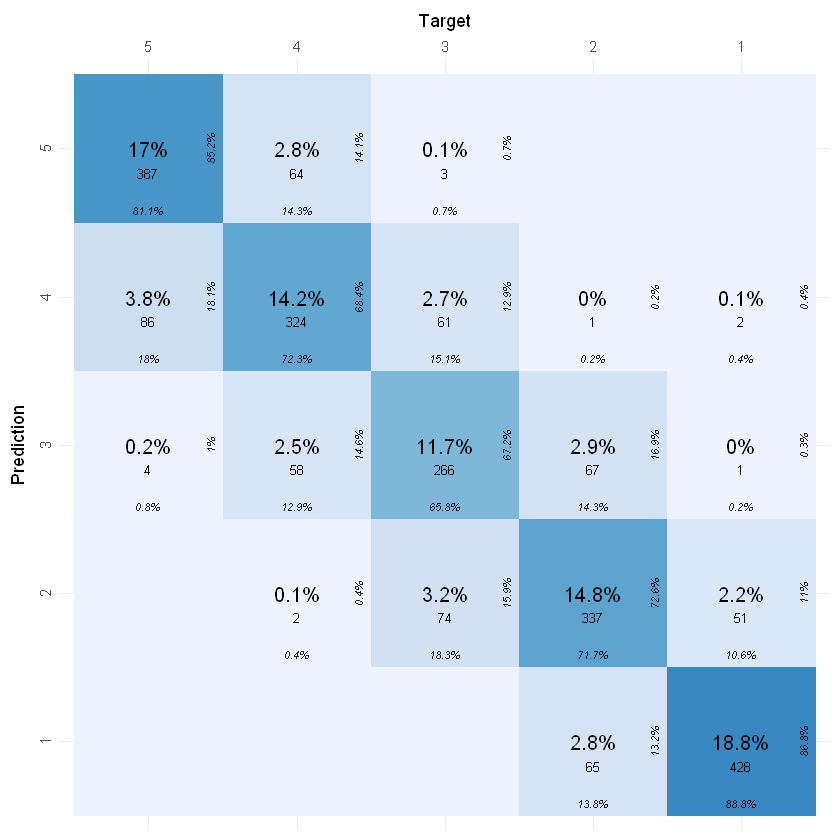

In [31]:
plot_confusion_matrix(confusion_matrix(targets=test.Y$Pos, prediction=rf.pred))

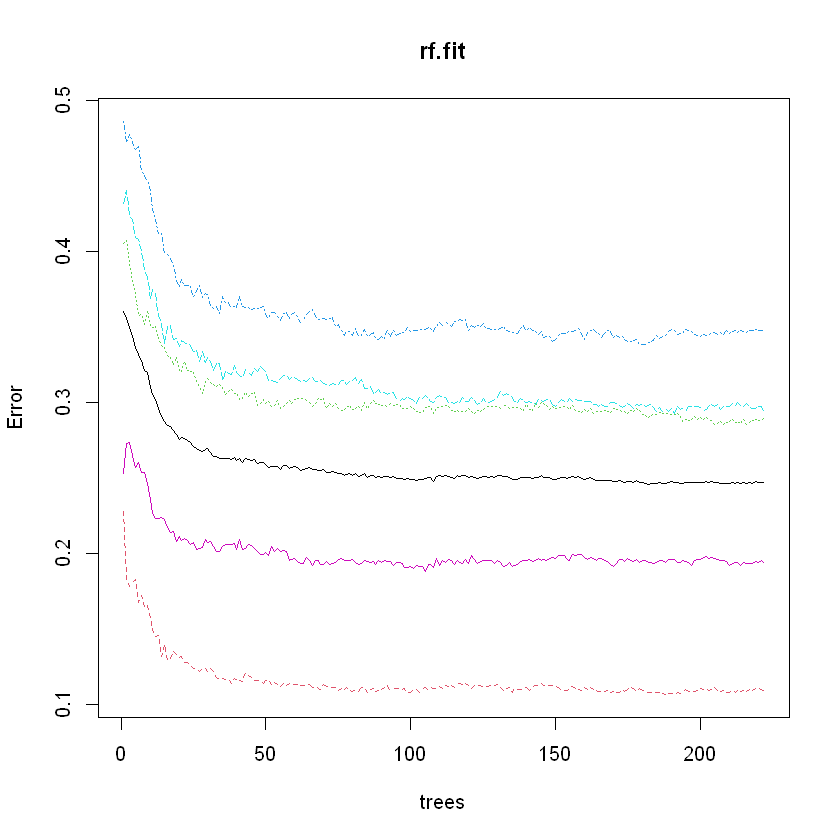

In [33]:
plot(rf.fit)

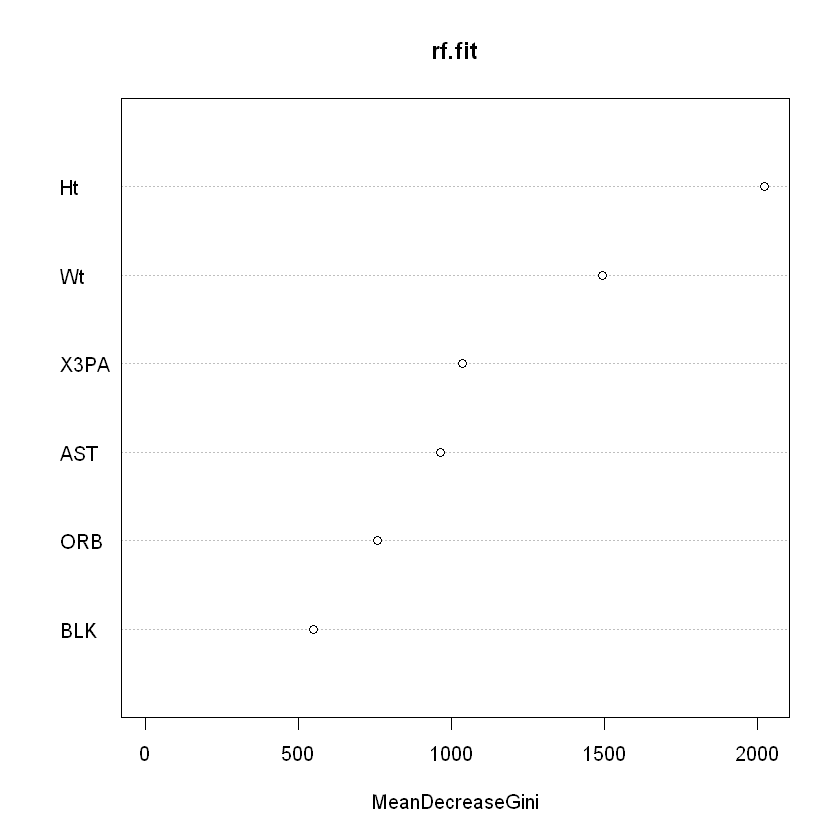

In [23]:
varImpPlot(rf.fit)

In [32]:
stats <- ml_test(rf.pred, test.Y$Pos, output.as.table=FALSE)
rf.results <- data.frame(
    Accuracy = stats$accuracy,
    Bias = mean(abs(as.integer(population.pred) - as.integer(rf.pred))),
    Variance = var(as.integer(population.pred), as.integer(rf.pred))
)
rf.results

Accuracy,Bias,Variance
<dbl>,<dbl>,<dbl>
0.7637001,0.2349847,1.959283


This model very good results. The highest accuracy, with relatively low computation time. Since Random forest is more flexible version of Decision Tree, it obvious why Variance is high, but I expected smaller bias. Probably the problem is with my data.

Also I would like to notice, that feature importance for Random forest completely corresponds to the one, ANOVA predicted. Very nice!

## Bagging

In [11]:
bag.fit <- bagging(formula = Pos ~ ., data = train, nbagg = 150, coob = TRUE,
  control = rpart.control(minsplit = 2, cp = 0)
)
population.bag <- bagging(formula = Pos ~ ., data = data, nbagg = 150, coob = TRUE,
  control = rpart.control(minsplit = 2, cp = 0)
)

bag.pred <- predict(bag.fit, newdata = test.X)
population.pred <- predict(population.bag, newdata = test.X)

bag.fit


Bagging classification trees with 150 bootstrap replications 

Call: bagging.data.frame(formula = Pos ~ ., data = train, nbagg = 150, 
    coob = TRUE, control = rpart.control(minsplit = 2, cp = 0))

Out-of-bag estimate of misclassification error:  0.2511 


Warning message in plot_confusion_matrix(confusion_matrix(targets = test.Y$Pos, :
"'ggimage' is missing. Will not plot arrows and zero-shading."
Warning message in plot_confusion_matrix(confusion_matrix(targets = test.Y$Pos, :
"'rsvg' is missing. Will not plot arrows and zero-shading."


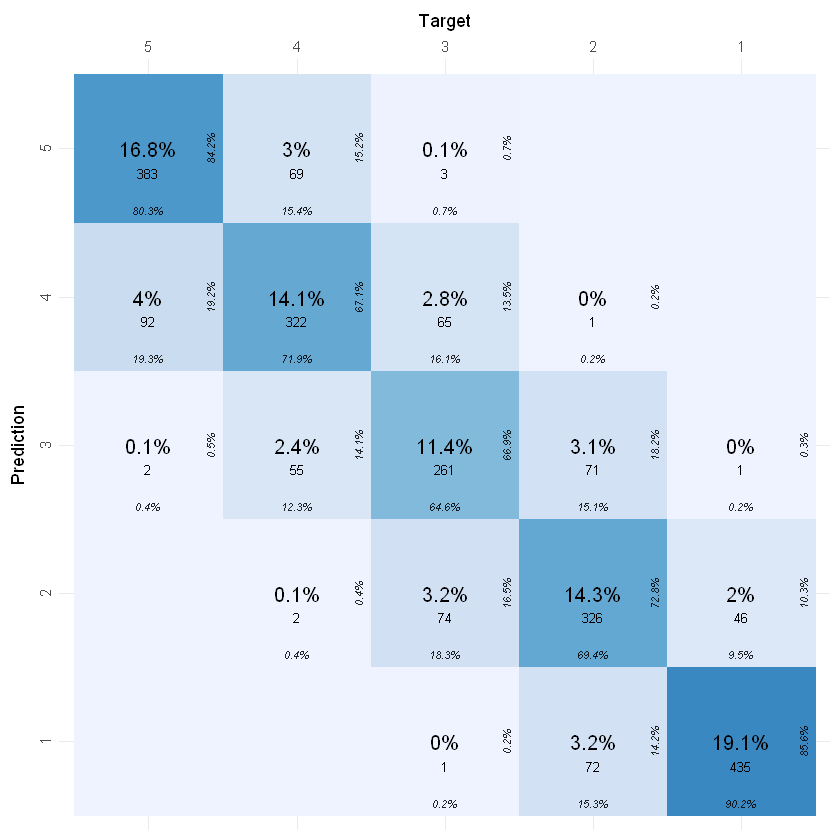

In [12]:
plot_confusion_matrix(confusion_matrix(targets=test.Y$Pos, prediction=bag.pred))

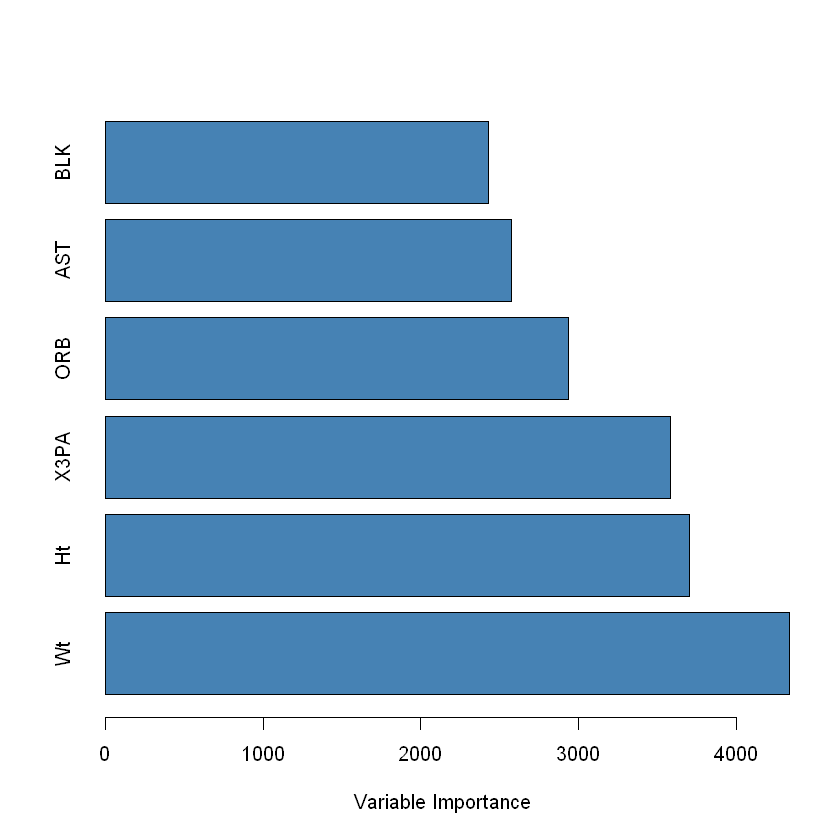

In [35]:
VI <- data.frame(var=names(data[,-1]), imp=varImp(bag.fit))
VI_plot <- VI[order(VI$Overall, decreasing=TRUE),]
barplot(VI_plot$Overall,
        names.arg=rownames(VI_plot),
        horiz=TRUE,
        col='steelblue',
        xlab='Variable Importance')

In [13]:
stats <- ml_test(bag.pred, test.Y$Pos, output.as.table=FALSE)
bag.results <- data.frame(
    Accuracy = stats$accuracy,
    Bias = mean(abs(as.integer(population.pred) - as.integer(bag.pred))),
    Variance = var(as.integer(population.pred), as.integer(bag.pred))
)
bag.results

Accuracy,Bias,Variance
<dbl>,<dbl>,<dbl>
0.7571241,0.2446295,1.964047


Bagging showed good results, but here, as with the RF, I am surprissed with big bias. Also the feature importance is similar to the one's ANOVA predicted.